# Implémentation bout à bout de l'algorithme skip-gram avec TensorFlow 2

Ce notebook contient le code d'implémentation de l'algorithme skip-gram. Skip-gram est une méthode de Word2Vec qui consiste à déterminer une représentation numérique d'un mot (**word embedding**). Word2Vec est l'une des avancées majeures de la recherche en NLP. En effet, cette méthode introduite en 2013 par des chercheurs de Google a permis d'avoir une représentation numérique des mots capable de comprendre leurs contextes d'utilisation. Elle consiste à déterminer un espace multidimensionnel où les mots qui ont une proximité sémantique sont plus proches. Ainsi, deux mots ayant des sens proches seront représentés par des vecteurs proches.  
La représentation numérique des mots est une étape indispensable dans les taches du traitement automatique des langues car les modèles de Machine Learning n'acceptent pas, comme inputs, les mots à l'état brut. L'avantage principal des techniques avancées de word embedding dont  Word2Vec sur les approches traditionnelles de représentation numérique des mots(bag of words, one hot encoding, tf-idf) est leur capacité à comprendre le contexte d'utilisation d'un mot.

## Importation des packages python nécessaires

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import random
from tqdm import tqdm
import zipfile
import os
import requests
import pandas as pd
from sklearn.manifold import TSNE
import joblib

## Récupération et chargement des données d'entrainement du modèle
Pour entrainer l'algorithme skip-gram, nous allons utiliser des données provenant du site  http://mlg.ucd.ie/datasets/bbc.html. Ces données se composent de 2 225 documents de la BBC correspondant à des articles dans cinq domaines d'actualité (affaires, divertissement, politique, sport, technologie) de 2004 à 2005. 
Pour faciliter l'étape de récupération des données, nous définissons une fonction qui permet de créer automatiquement un repertoire de stockage et y télécharger les données. Le téléchargement consiste à récpérer le fichier **bbc-fulltext.zip** et extraire ensuite son contenu. Lorsque le repertoire et/ou les données existe(nt) déjà, la fonction affiche un message dans ce sens. La fonction prend en parametres le nom du dossier de stockage, à créer s'il n'existe pas,  et l'url de récupération des données.  
Pour le chargement des données en mémoire, nous allons créer une autre fonction. Cette fonction prend en paramètre le chemin du dossier contenant les sous-dossiers thématiques, extraie les textes des différents articles dans une liste python et crée un objet Dataset de TensorFlow. La la fonction retourne un objet Dataset.

In [2]:
# Fonction de récuperation des données
def download_data(data_dir, url):
    
    """
    Cette fonction crée un repertoire data_dir (s'il n'existe pas), 
    y télécharge le fichier bbc-fulltext.zip et extraie le contenu 
    de ce dernier. Elle prend deux paramètres data_dir qui est le nom 
    du dossier de stockage et url qui correspond à l'adresse de récupération 
    des données.
    """
    # Créer un dossier de stockage data_dir s'il n'existe pas encore
    
    os.makedirs(data_dir, exist_ok=True)
    
    # Télécharger le fichier des données s'il n'existe pas encore
    # le chemin du fichier bbc-fulltext.zip contenant les dossiers 
    # d'articles regroupés par thème d'actualités
    
    file_path = os.path.join(data_dir,"bbc-fulltext.zip") 
    
    # verifier l'existence du fichier bbc-fulltext.zip
    if not os.path.exists(file_path): 
        
        print("Téléchargement des données...")
        
        resp = requests.get(url) # récupérer le fichierbbc-fulltext.zip
        
        with open(file_path, mode='wb') as f: 
            
            f.write(resp.content) # enregistrement du fichier sur le disque
    else:
        print("Le ficher bbc-fulltext.zip existe déjà!")
    
    # Extraction du contenu du fichier .zip
    
    extract_path = os.path.join(data_dir, 'bbc')
    
    if not os.path.exists(extract_path):
        
        with zipfile.ZipExtFile(file_path,mode='r') as zipf:
            
            zipf.extractall(data_dir)
    else:
        print("Le contenu du fichier bbc-fulltext.zip est déjà extrait!")

data_dir = 'data'
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'
download_data(data_dir=data_dir, url=url)

Le ficher bbc-fulltext.zip existe déjà!
Le contenu du fichier bbc-fulltext.zip est déjà extrait!


In [3]:
# Définition de la fonction de chargement des données en mémoire
def read_data(data_dir):
    """
    Cette fonction permet de charger les données en mémoire 
    dans un objet Dataset. Elle prend un paramètre data_dir 
    correspondant à la racine du dossier contenant les données. 
    Elle retourne un objet Dataset.
    """
    print("Lecture des fichiers...")
    
    news_stories = []
    # Parcourir chaque dossier, y compris le dossier principal (data_dir), 
    # ses sous-dossiers et les contenus de ces derniers.
    for root, dirs, files in os.walk(data_dir): 
        
        # Parcourir la liste des fichiers contenu dans chaque dossier
        for fi, f in enumerate(files): 
            # Ignorer le dossier s'il contient le fichier README. 
            # Cela permet d'ignorer le dossier principal qui ne 
            # contient pas directement les articles.
            
            if 'README' in f:
                
                continue 
               
            print("."*fi,f, end='\r') 
             # end = \r pour de ne pas afficher tout à l'écran
            with open(os.path.join(root,f), mode='r', encoding='latin-1') as f:
                
                story = [] # une liste pour chaque article
                
                for row in f:
                     # Ajouter chaque ligne à la liste story en eliminant 
                     # l'espace inutile avec la méthode strip()
                    story.append(row.strip())
                # Assembler les différentes lignes de chaque article 
                # pour former un seul texte    
                story = ' '.join(story) 
                # Ajouter le texte de chaque article à la grande liste 
                # pour obtenir une liste dont les éléments sont les textes 
                # des articles.
                news_stories.append(story) 
    # Afficher le nombre total d'articles détectés                
    print(f"\n{len(news_stories)} articles ont été détectés.") 
    
    text_ds = tf.data.Dataset.from_tensor_slices(news_stories)
    
    return text_ds

data_dir = os.path.join('data','bbc')
news_stories_ds = read_data(data_dir)

Lecture des fichiers...
................................................................................................................................................................................................................................................................................................................................................................................................................ 401.txt...................................................................................................... 511.txt
2225 articles ont été détectés.


## Génération des skip-grams
L'algorithme skip-gram consiste à prédire la probabilité qu'un mot (contexte) apparaisse dans le contexte d'usage d'un autre mot (target). Il transforme ainsi le problème non supérvisé en un problème supérvisé en créant une variable binaire (y) qui prend 1 si les deux mots apparaissent ensemble et 0 sinon. Comme les données ne se présentent pas, à la base dans cette configuration, il est nécessaire de déterminer les mots qui apparaissent dans le contexte d'un mot donné dans une certaine fénêtre et quelques mots qui n'y apparaissent. Pour trouver les mots qui font partie du contexte d'un mot, il est facile une fois qu'on a choisi la fénêtre mais le choix des mots non présents dans le contexte pourrait présenter un peu plus de challenge car il peut avoir plusieurs candidats négatifs possibles. Il se pose donc la question de la procédure de leur sélection et de leur nombre. Une méthode consisterait à attribuer une distribution uniforme à tous les mots du corpus et à procéder à un échantillonnage après avoir choisi le nombre des candidats négatifs voulus. Cette méthode à l'inconvenient de défavoriser les mots qui sont très rares dans le texte. Une méthode alternative consiste à utiliser la loi de Zipf. Cette loi empirique dit en gros que la fréquence d'un mot dans un texte est proportionnelle à son rang. Selon cette loi, la fréquence d'apparition d'un mot de rang k dans un ensemble de N mots est donnée par la formule suivante: 
$$f_k =\dfrac{k^{-s}}{\sum_{i=1}^{i=N}n^{-s}}$$  
Il y a deux fonctions de keras qui permettent de déterminer respectivement les skip-grams positifs et les skip-grams négatifs à partir de quelques paramètres. La fonction de génération de skip-grams positifs utilise, dans ses paramètres, une table d'échantillonge contenant, pour chaque mot, la probabilité de sélection basée sur la loi de Zipf et déterminée suivant la formule suivante (le paramètre t est à définir, sa valeur par défaut est de 0.00001):
$$p\left(w_i\right) = 1- \sqrt{\dfrac{t}{f\left(w_i\right)}}$$  
Cette méthode de sous-échantillonage permet d'améliorer la performance du modèle en limitant la sélection des mots fréquents mais sans grand apport d'information comme les stopwords.  
Nous allons créer un fonction qui permet de générer les skip-grams (positifs et négatifs) et leurs labels respectifs.

In [4]:
def generate_skip_gram_data(sequences, window_size,
                            negative_samples, vocab_size, seed=None):
    
    """
    Cette fonction permet de générer des skip-grams positifs et négatifs 
    pour chacun des mots d'une séquence. Elle retourne une liste des IDs 
    des mots cibles, une liste des IDs des mots de context qui leur 
    correspondent et une liste des labels (0 et 1). La fonction prend 
    plusieurs paramètres définis ci-après.
    Args:
    - sequences(list(list(int))): c'est une liste des listes de IDs
    des mots 
    - window_size(int) : c'est la fénêtre dans laquelle on cherche les 
    mots de contexte
    - negative_samples (int) : c'est le nombre des candidats négatifs 
    souhaités pour chaque mot
    - vocab_size(int): c'est la longueur du corpus des mots
    - seed(int): c'est une graine pour la génération des nombres 
    pseudo-aléatoires
    Returns:
    - une liste des IDs des mots cibles
    - une liste des IDs des mots de context ( positifs et négatifs)
    - une liste des labels (0 et 1)
    """
    
    # Listes globales pour stocker tous les targets, contexts 
    # et les labels d'une séquence
    targets, contexts, labels = [], [], []
    
    # Génération de table d'échantillonage
    sampling_table = tf.keras.preprocessing.sequence\
    .make_sampling_table(vocab_size, sampling_factor=1e-05)
    
    # Itérer sur les séquences
    for sequence in tqdm(sequences):
        
        # Générer les skip-grams psoitifs
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,vocabulary_size=vocab_size,window_size=window_size,
            negative_samples=0,shuffle=False,sampling_table=sampling_table,
            seed=seed
            )
        
        # Générer des skip-grams négatifs pour chaque 
        # target_word du positive_skip_grams
        for target_word, context_word in positive_skip_grams:
            # la classe positive
            context_class = tf.expand_dims(tf.constant([context_word],
                                                       dtype='int64'),axis=1) 
            negative_sampling_candidates, _, _ = tf.random\
            .log_uniform_candidate_sampler(true_classes=context_class, 
                                           num_true=1,
                                           num_sampled=negative_samples,
                                           unique=True,
                                           range_max=vocab_size,
                                           name='negative_sampling')
            # Créer un vecteur de contextes pour chaque mot target: 
            #context_word + negative_sampling_candidates
            context = tf.concat([tf.constant([context_word], 
                                dtype='int64'), 
                                negative_sampling_candidates], 
                                axis=0)
            
            # Créer un vecteur de labels pour chaque mot target : 
            # 1 pour context_word et 0 pour les negative_samples
            label = tf.constant([1] + [0]*negative_samples, dtype='int64')
            
            # Intégrer chaque élément dans les listes globales
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
        
    return targets, contexts, labels
               

## Préparation des données : standardisation, tokénisation et vectorization
La tokénisation consiste à découper une séquence (une phrase par exemple) en unités plus pétites (mots par exemple). La standardisation est un prétraitement des données consistant notamment à supprimer les ponctuations ou des éléments html pour simplifier le texte. La classe **tf.keras.layers.TextVectorization** de TensorFlow permet d'effectuer toutes les trois opérations.

In [5]:
# Définition des hyperparamètres
AUTOTUNE=tf.data.AUTOTUNE
VOCAB_SIZE = 20000 
BATCH_SIZE = 4096
BUFFER_SIZE = 1000
EMBEDDING_SIZE = 128
WINDOW_SIZE = 1
NEGATIVE_SAMPLES = 10
EPOCHS = 42
VALID_SIZE = 5
VALID_WINDOW = 250
SEED = 42

In [6]:
# Instancier une couche de vectorisation
vectorize_layer = tf.keras.layers.TextVectorization(output_mode='int', 
                                                    max_tokens= VOCAB_SIZE) 

# Déterminer le vocabulaire à partir des tokens grâce 
# à la méthode adapt() de TextVectorization

vectorize_layer.adapt(news_stories_ds.batch(445))

# Vectorisation de chaque élément de l'objet Dataset
news_stories_vector_ds = news_stories_ds.batch(445)\
                                        .prefetch(AUTOTUNE)\
                                        .map(vectorize_layer)\
                                        .unbatch()

# Détermination des séquences 
sequences = list(news_stories_vector_ds.as_numpy_iterator())
print(len(sequences))

2225


In [7]:
# Apperçu du vocabulaire
vectorize_layer.get_vocabulary()[1:10]

['[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'for', 'is']

## Génération des exemples d'entrainement à partir des séquences

In [8]:
# Génération des exemples d'entrainement à partir des séquences
targets, contexts, labels = generate_skip_gram_data(
    sequences=sequences,
    window_size=WINDOW_SIZE,
    negative_samples=NEGATIVE_SAMPLES,
    vocab_size=VOCAB_SIZE,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2225/2225 [01:54<00:00, 19.48it/s]


## Configuration du dataset pour la performance

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size = AUTOTUNE)
print(dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(4096,), dtype=tf.int64, name=None), TensorSpec(shape=(4096, 11), dtype=tf.int64, name=None)), TensorSpec(shape=(4096, 11), dtype=tf.int64, name=None))>


## Données de validation du modèle
Pour la validation du modèle, on choisit, aléatoirement, quelques mots au début du corpus et quelques autres au milieu et calculer les 5 mots qui leur sont les
proches. Au fur et à mesure que la performance du modèle s'améliore, les 5 voisins les plus proches des mots de validation devraient être plus précis (vraisemblables).

In [10]:
# Définissons un ensemble de validation du modèle
valid_term_ids = np.array(random.sample(range(VALID_WINDOW), VALID_SIZE))
valid_term_ids = np.append(valid_term_ids, random.sample(range(1000,1000 + VALID_WINDOW), VALID_SIZE), axis=0)

## Modélisation

In [11]:
# Création d'une classe de modèle
class SkipGramModel(tf.keras.Model):

    def __init__(self, vocab_size, embedding_size):
        
        super(SkipGramModel, self).__init__()
        
        self.target_embedding_layer = tf\
        .keras.layers.Embedding(input_dim=vocab_size, 
                                output_dim=embedding_size, 
                                name = 'target_embedding')
        self.context_embedding_layer = tf\
        .keras.layers.Embedding(input_dim=vocab_size, 
                                output_dim=embedding_size, 
                                name = 'context_embedding')

    def call(self, pair):
        target, context = pair
                  
        # target: (batch,)
        target_out = self.target_embedding_layer(target)
        
        # word_emb: (batch, embed)
        context_out = self.context_embedding_layer(context)
        
        # context_emb: (batch, context, embed)
        out = tf.keras.layers.Dot(axes=-1)([target_out, context_out])
        
        # dots: (batch, context)
        return out

In [12]:
# Nous crééons une classe personnalisée de callback 
# héritant de la classe Callback de keras pour la validation du modèle
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_term_ids, model_with_embeddings, vocabulary):
        self.valid_term_ids = valid_term_ids
        self.model_with_embeddings = model_with_embeddings
        self.vocabulary = vocabulary
        super().__init__()
        
    def on_epoch_end(self, epochs, logs=None):
        
        """Validation logic."""
        # Nous utilisons les embeddings des contextes pour la validation
        embedding_weights = self.model_with_embeddings\
        .get_layer('context_embedding').get_weights()[0]
        norm_embedding_weights = embedding_weights\
        /np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))
        
        # Récupérer les embeddings correspondant aux IDs 
        # de validation valid_tervalid_term_ids
        valid_term_embeddings = norm_embedding_weights[self.valid_term_ids, :]
        
        # Calculer la similarité entre valid_term_embeddings 
        # et tous les embeddings
        top_k = 5
        similarity = np.dot(valid_term_embeddings, norm_embedding_weights.T)
        
        # Transformer la matrice de similarité en négative 
        # Ignorer le premier mot comme il correspondra toujours 
        # au mot de validation lui même 
        similarity_top_k = np.argsort(-similarity, axis=1)[:, 1:top_k + 1]
        
        # Afficher le résultat
        for i, term_id in enumerate(valid_term_ids):
            similar_word_str = ','.join(
                [self.vocabulary[j] for j in similarity_top_k[i,:] if j >= 1]
                                       )
            print(f"\n{self.vocabulary[term_id]} : {similar_word_str}")
        
        print('\n')

In [13]:
# Effacer tous les états précédents générés par keras
K.clear_session() 

# Instanciation du modèle
skip_gram_model = SkipGramModel(VOCAB_SIZE, EMBEDDING_SIZE)

# Compilation du modèle
optimizer = tf.optimizers.Adam()
loss_fn = tf.losses.BinaryCrossentropy(from_logits=True)
skip_gram_model.compile(loss=loss_fn, 
                        optimizer = optimizer, 
                        metrics=['accuracy'])

## Entrainement et validation

In [14]:
# Définition de la callback
vocabulary = vectorize_layer.get_vocabulary()
skipgram_val_callback = ValidationCallback(valid_term_ids,
                                                  skip_gram_model, 
                                                  vocabulary)

# Entrainement du modèle
skip_gram_model.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[skipgram_val_callback])

Epoch 1/42
88/88 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.0864
what : [UNK],a,for,it

than : the,[UNK],was,its

top : has,[UNK],it,for

future : for,to,[UNK],in,it

you : to,and,on,[UNK]

facing : can,also,up,figures,playing

4 : support,with,likely,told,but

controversial : brown,drop,quarter,my,out

america : his,that,next,much,england

politics : third,we,has,four,used


88/88 [==============================] - 7s 71ms/step - loss: 0.6870 - accuracy: 0.0864
Epoch 2/42
88/88 [==============================] - ETA: 0s - loss: 0.5729 - accuracy: 0.0821
what : [UNK],it,its,from

than : would,its,with,[UNK]

top : has,with,last,it

future : there,would,for,from

you : to,people,with,their

facing : can,up,figures,also,there

4 : with,support,but,told,bbc

controversial : brown,my,after,do,out

america : his,much,we,next

politics : we,has,it,third,will


88/88 [==============================] - 6s 69ms/step - loss: 0.5729 - accuracy: 0.0821
Epoch 3/42
88/88

In [15]:
skip_gram_model.summary()

Model: "skip_gram_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 target_embedding (Embeddin  multiple                  2560000   
 g)                                                              
                                                                 
 context_embedding (Embeddi  multiple                  2560000   
 ng)                                                             
                                                                 
Total params: 5120000 (19.53 MB)
Trainable params: 5120000 (19.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Sauvegarde des embeddings

In [16]:
def save_embeddings(save_dir, model_with_embeddings, vocabulary):
    
    os.makedirs('embeddings',exist_ok=True)
    
    sorted_words = vocabulary
    
    sorted_words[0] = None
    
    context_embeddings = pd.DataFrame(model_with_embeddings\
                                      .get_layer('context_embedding')\
                                      .get_weights()[0],index=sorted_words)
    
    target_embeddings = pd.DataFrame(model_with_embeddings\
                                     .get_layer('target_embedding')\
                                     .get_weights()[0],index=sorted_words)
    
    joblib.dump(value=context_embeddings,
                filename=os.path.join(save_dir,"context_embedding.joblib")
                ,compress=0)
    
    joblib.dump(value=target_embeddings,
                filename=os.path.join(save_dir, "target_embedding.joblib")
                ,compress=0)    

    
save_embeddings('embeddings',skip_gram_model, vocabulary)

## Visualisation des résultats de l'algorithme skip-gram  
Pour procéder à une représentation graphique des résultats de l'algorithme, nous utilisons la méthode de réduction de dimension dite t-SNE. 

In [17]:
context_words_embeddings = joblib.load('./embeddings/context_embedding.joblib')
tsne = TSNE(n_components=2, metric='cosine')
skipgram_words= np.array(context_words_embeddings.index) 
skip_gram_embeddings = context_words_embeddings.values
skip_gram_embeddings_norm = skip_gram_embeddings / \
np.sum(skip_gram_embeddings**2, axis=1, keepdims=True) 
tsne_embeddings = tsne.fit_transform(skip_gram_embeddings_norm)

Représentation de 1500 mots

Ajustement des textes d'annotation sur le graphique.
Cela pourrait prendre quelque temps: 357 Annotations



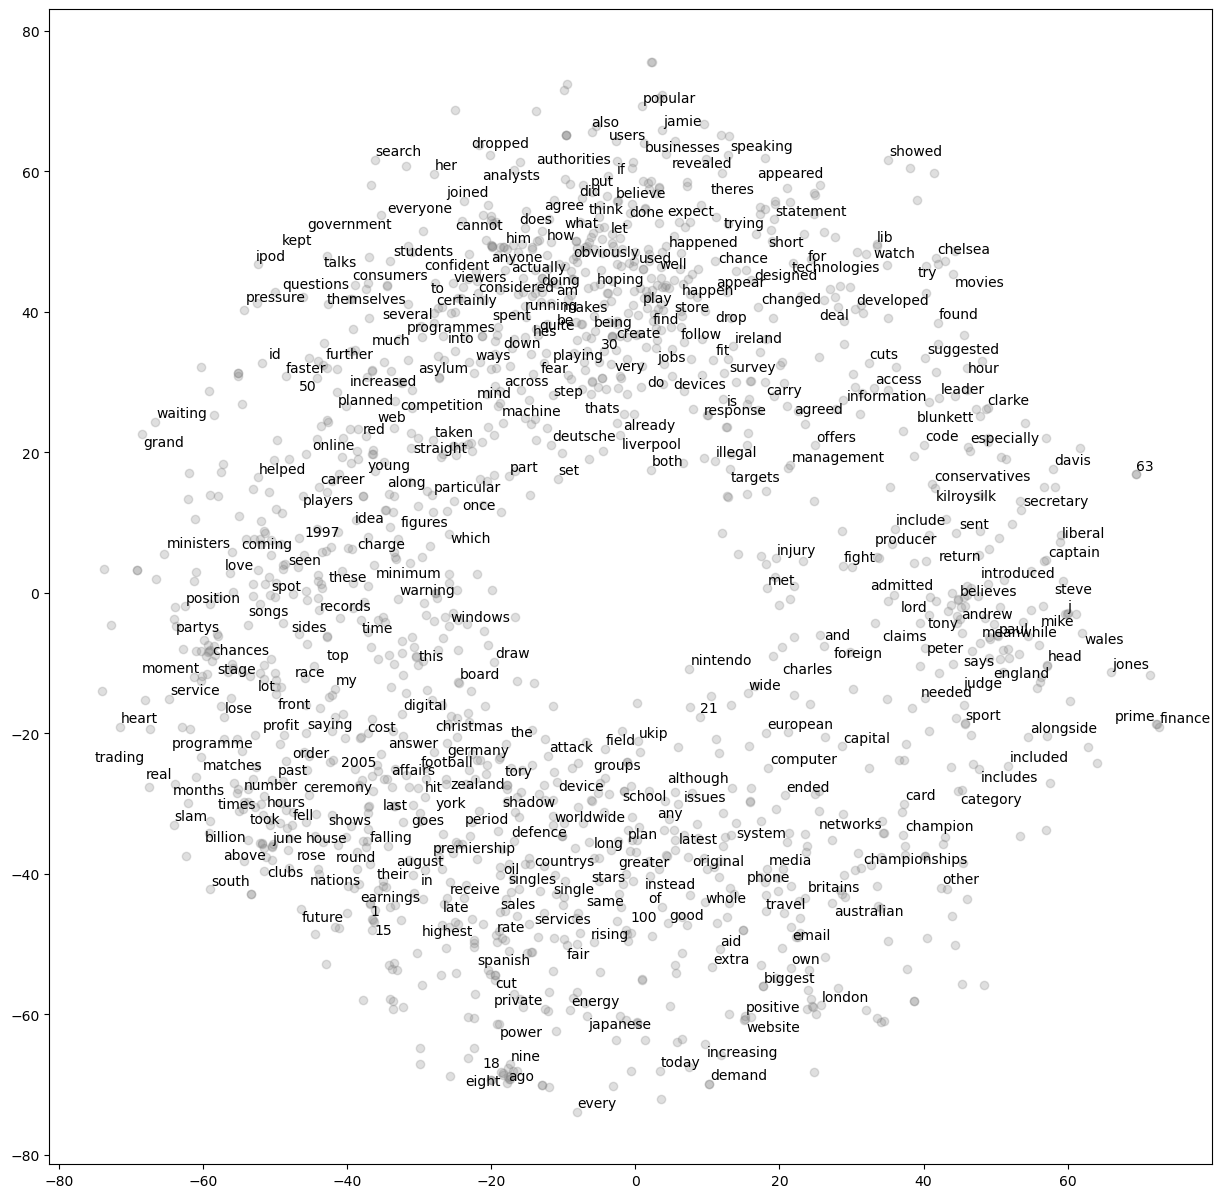

In [24]:
def plot_words_embeddings(embeddings, labels):
    print(f"Représentation de {embeddings.shape[0]} mots")
    
    plt.figure(figsize=(15,15)) 
    
    # Représenter tous les embeddings et les mots correspondants
    plot_annotations = []
    
    for i, label in enumerate(labels):
        
        x, y = embeddings[i,:]
        plt.scatter(x, y, alpha=0.25, c='gray')
        
        #  On choisit d'annoter seulement une partie des données
        # pour éviter des temps d'attente longs
        if np.random.normal()>0.75:
            plot_annotations.append(
                plt.text(x, y, label, ha='center', va='center', fontsize=10)
            )
    
    print(
f"""
Ajustement des textes d'annotation sur le graphique.
Cela pourrait prendre quelque temps: {len(plot_annotations)} Annotations
"""
    )
    adjust_text(plot_annotations)
    
    # Enregistrement du graphique
    plt.savefig('word_embeddings.png')
    plt.show()

    
plot_words_embeddings(tsne_embeddings[1:1501], skipgram_words[1:1501])
